<a href="https://www.kaggle.com/code/jbngcrs/titanic-competition-xgboost?scriptVersionId=119429703" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#Importing Libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import os
from scipy.stats import mode
import string
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
#Loading data 
df_train = pd.read_csv('../input/titanic/train.csv')
df_test = pd.read_csv('../input/titanic/test.csv')
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
#Checking the numbers of columns and rows
rows = len(df_train.axes[0])
columns = len(df_train.axes[1])

print("Number of Rows:",rows)
print("Number of Columns:",columns)

#Checking of Data Types
df_train.info()


Number of Rows: 891
Number of Columns: 12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


    It shows that all columns are in a correct data types as of now. After checking the data types and number of columns and rows, We can now proceed to cleaning and exploring the data. 

In [4]:
#Checking of null values
missing_values_count = df_train.isnull().sum()
missing_values_count[0:]


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

It shows that there are 177 missing values out of 891 in column Age , 687 missing values out of 891 in column cabin and 2 missing values out of 891 in Column Embarked. We can replace the missing value in Column Age by its mean and In column Embarked, we can replace the missing values by its mode. While in Cabin column, we will extract it since it contains the the letter of the deck. Also, I created a new column 'Died' 

In [5]:
#Data Manipulation and Feature Engineering
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    print (big_string)
    return np.nan
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
df_train['Cabin'] = df_train['Cabin'].fillna('Unknown') 
df_train['Deck']=df_train['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
df_train['Age'].replace([np.nan],df_train['Age'].mean(),inplace=True)
df_train['Embarked'].replace([np.nan],df_train['Embarked'].mode(),inplace=True)
#Extracting the Died passenger from the Survived Column
df_train['Died'] = 1 - df_train['Survived']
#Scaling the Age and Fare data values 
df_train['Age'] = (df_train['Age']-min(df_train['Age']))/(max(df_train['Age']-min(df_train['Age'])))
df_train['Fare'] = (df_train['Fare']-min(df_train['Fare']))/(max(df_train['Fare']-min(df_train['Fare'])))
df_train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Died
0,1,0,3,"Braund, Mr. Owen Harris",male,0.271174,1,0,A/5 21171,0.014151,Unknown,S,Unknown,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.472229,1,0,PC 17599,0.139136,C85,C,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,0.321438,0,0,STON/O2. 3101282,0.015469,Unknown,S,Unknown,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.434531,1,0,113803,0.103644,C123,S,C,0
4,5,0,3,"Allen, Mr. William Henry",male,0.434531,0,0,373450,0.015713,Unknown,S,Unknown,1


Let's start exploring the columns 

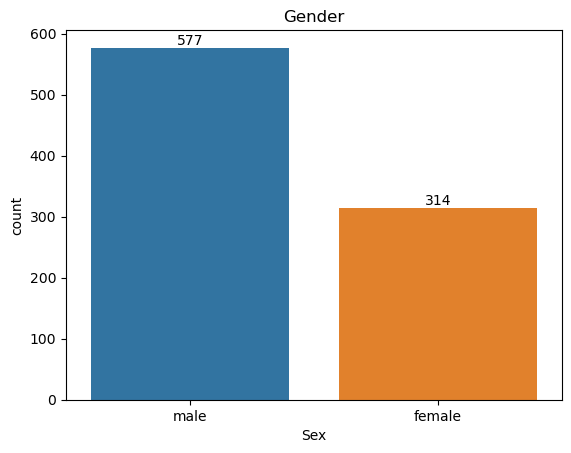

In [6]:
#Data Exploration
z = sns.countplot(x='Sex',data=df_train)
plt.title("Gender")
for i in z.containers:
    z.bar_label(i,)

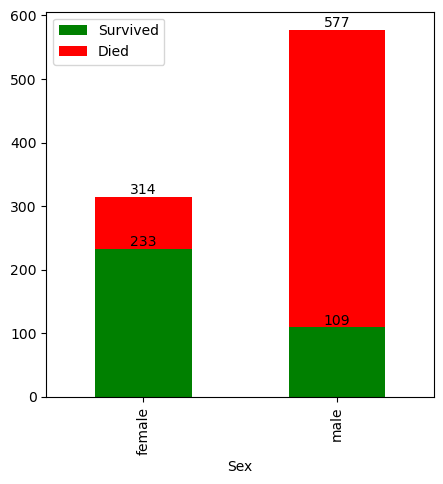

In [7]:
z1 = df_train.groupby('Sex').agg('sum')[['Survived','Died']].plot(kind='bar',figsize = (5,5),stacked=True,color = ['Green', 'red'])
for i1 in z1.containers:
    z1.bar_label(i1,)

There are only 233 female passengers survivor out of 314 while 109 male survivor out of 577. It only shows that 81 female and 468 male passenger died. 

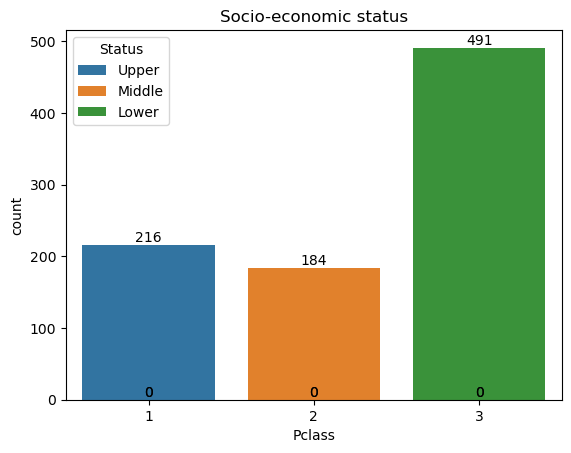

In [8]:
z2 = sns.countplot(x='Pclass',hue='Pclass',data=df_train,dodge=False)
plt.title("Socio-economic status")
plt.legend(title='Status', loc='upper left', labels=['Upper', 'Middle','Lower'])
for i2 in z2.containers:
    z2.bar_label(i2,)

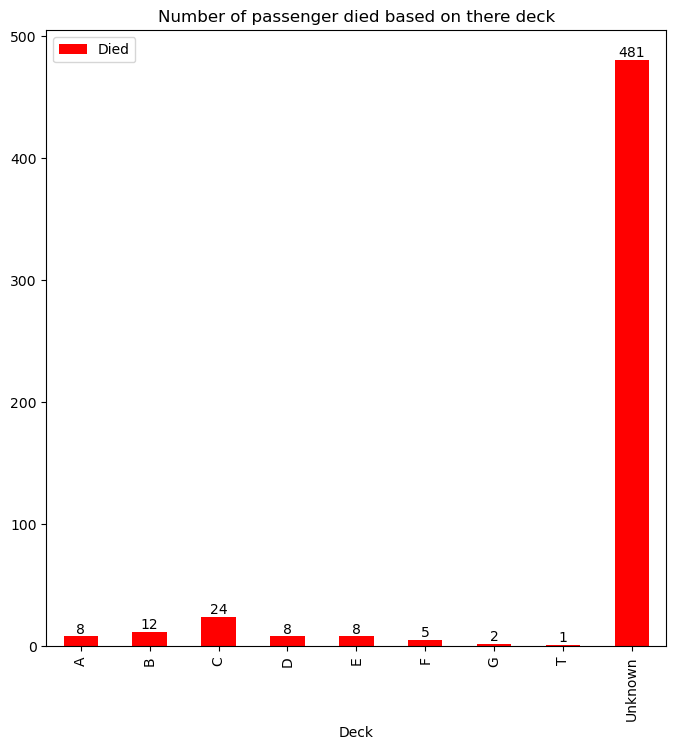

In [9]:
z3 = df_train.groupby('Deck').agg('sum')[['Died']].plot(kind='bar',figsize = (8,8),stacked=True,color = ['red'])
plt.title("Number of passenger died based on there deck")
for i in z3.containers:
    z3.bar_label(i,)

That's all for the EDA. Now, lets build our model. I'm gonna use the XGBoost. 

In [10]:
#Setting the load data in variable X and X_test
X = df_train
X_test = df_test

#Setting predicion target
y = X.Survived
X.drop(['Survived','Name','Ticket','Cabin','Died','PassengerId'],axis=1,inplace=True)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [11]:
# Apply ordinal encoder to the X_train_full dataset
s = (X_train_full.dtypes == 'object')
object_cols = list(s[s].index)
ordinal_encoder = OrdinalEncoder()
X_train_full[object_cols] = ordinal_encoder.fit_transform(X_train_full[object_cols])
X_valid_full[object_cols] = ordinal_encoder.transform(X_valid_full[object_cols])


In [12]:
#Hypertuning the XGBoostModel 
params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}
XGBmodel = XGBRegressor(seed = 20)
clf = RandomizedSearchCV(estimator=XGBmodel,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1)
clf.fit(X_train_full,y_train)
prediction = clf.predict(X_valid_full)
mae = mean_absolute_error(prediction,y_valid)
print("Mean Absolute Error:" , mae)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Mean Absolute Error: 0.24753784646953889


In [13]:
X_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [14]:
#Data Manipulation and Feature Engineering in Test Data
X_test['Age'].replace([np.nan],X_test['Age'].mean(),inplace=True)
X_test['Fare'].replace([np.nan],X_test['Fare'].median(),inplace=True)
X_test['Cabin'] = X_test['Cabin'].fillna('Unknown') 
X_test['Age'] = (X_test['Age']-min(X_test['Age']))/(max(X_test['Age']-min(X_test['Age'])))
X_test['Fare'] = (X_test['Fare']-min(X_test['Fare']))/(max(X_test['Fare']-min(X_test['Fare'])))
X_test['Deck']= X_test['Cabin'].map(lambda x: substrings_in_string(x, cabin_list))
X_test1 = X_test.drop(['Name','Ticket','Cabin','PassengerId'],axis=1)

In [15]:
X_test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    object 
 7   Deck      418 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 26.2+ KB


For the cell below, if you recieved the error "ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''" just retry to run the code. 

In [16]:
# Apply ordinal encoder to the object columns in X_test data
s = (X_test1.dtypes == 'object')
object_cols1 = list(s[s].index)

ordinal_encoder1 = OrdinalEncoder()
X_test1[object_cols1] = ordinal_encoder1.fit_transform(X_test1[object_cols1])
X_test1

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
0,3,1.0,0.452723,0,0,0.015282,1.0,7.0
1,3,0.0,0.617566,1,0,0.013663,2.0,7.0
2,2,1.0,0.815377,0,0,0.018909,1.0,7.0
3,3,1.0,0.353818,0,0,0.016908,2.0,7.0
4,3,0.0,0.287881,1,1,0.023984,2.0,7.0
...,...,...,...,...,...,...,...,...
413,3,1.0,0.396975,0,0,0.015713,2.0,7.0
414,1,0.0,0.512066,0,0,0.212559,0.0,2.0
415,3,1.0,0.505473,0,0,0.014151,2.0,7.0
416,3,1.0,0.396975,0,0,0.015713,2.0,7.0


In [17]:
#Submission of the prediction result
test_pred = clf.predict(X_test1)
test_pred_new = np.rint(test_pred).astype(int)
submission = pd.DataFrame({
        "PassengerId": X_test['PassengerId'],
        "Survived": test_pred_new
    })
submission.to_csv('submission.csv', index=False)
pred_df = pd.read_csv('submission.csv')
pred_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


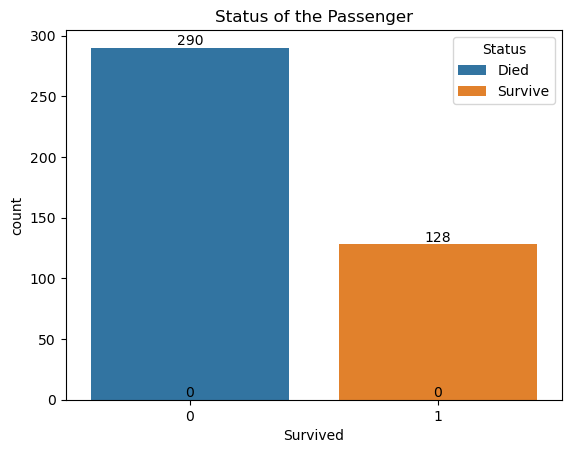

In [18]:
#Plotting the predict number of survivor and died passenger
z5 = sns.countplot(x='Survived',hue = 'Survived',data=pred_df,dodge=False)
plt.title("Status of the Passenger")
plt.legend(title='Status', loc='upper right', labels=['Died', 'Survive'])
for i5 in z5.containers:
    z5.bar_label(i5,)

That's all for my Titanic Competition entry. Would appreciate if you give points or suggestion to improve. I'm just a beginner wanting to learn more and be better. Thank you very much! 